In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count
max_cpu = cpu_count()

# Homework (Lecture 5)

## Problem 1

In [2]:
def load_data():
    df = pd.read_csv('boston.csv')
    X = df.drop(['ZN','CHAS','MEDV'],axis=1)
    Y = np.log10(df['MEDV'])
    return X,Y

def calc_ahat(X,Y,n,j,betas):
    prod = (Y - sum(X.drop(X.columns[j], axis=1) @ np.delete(betas,j)))
    a_hat = (1/n) * sum(X.iloc[:,j] * prod)
    return a_hat
    
def calc_betaj(X,Y,n,j,betas,lambda_):
    a_hat = calc_ahat(X,Y,n,j,betas)
    sign = np.sign(a_hat)
    max_right = max(np.abs(a_hat) - lambda_/2,0)
    beta_hat_j = sign * max_right
    return beta_hat_j

def lasso(X,Y,lambda_,epsilon=1e-6):
    n = X.shape[0]
    p = X.shape[1]
    betas = np.random.normal(size=p)
    err = 1
    while err > epsilon:
        last_beta = betas.copy()
        for j in np.arange(p):
            betas[j] = calc_betaj(X,Y,n,j,betas,lambda_)
        err = np.linalg.norm(betas-last_beta)
    return betas

def normalize(df):
    return (df - df.mean())/df.std()
    
def train_test_split(X,Y,folds,i):
    temp = folds[:]
    testing_idx = temp.pop(i)
    training_idx = np.concatenate(temp)
    X_train, X_test, Y_train, Y_test = X.iloc[training_idx,:], X.iloc[testing_idx,:], Y.iloc[training_idx,], Y.iloc[testing_idx,]
    X_train = normalize(X_train)
    X_train['const'] = 1
    X_test = normalize(X_test)
    X_test['const'] = 1
    return X_train, X_test, Y_train, Y_test

def sse(predicted,actual):
    return sum((predicted - actual) ** 2)

def cv(lambda_,k=5):
    X,Y = load_data()
    n = X.shape[0]
    # creating indices for folds
    folds = []
    remaining_idx = np.arange(n)
    for i in np.arange(k):
        indices = np.random.choice(remaining_idx,round(n * 1/k), replace=False)
        remaining_idx = np.setdiff1d(remaining_idx, indices)
        folds.append(indices)
        
    # calculating total error
    total_error = 0
    for i,_ in enumerate(folds):
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,folds,i)
        betas = lasso(X_train,Y_train,lambda_)
        predicted = X_test @ betas
        error = sse(predicted,Y_test)
        total_error += error
    return (betas, lambda_, total_error)

In [3]:
#%%timeit
lambdas = np.linspace(0,1,1000)
with ThreadPool(max_cpu - 1) as pool:
    output = pool.map(cv,lambdas)

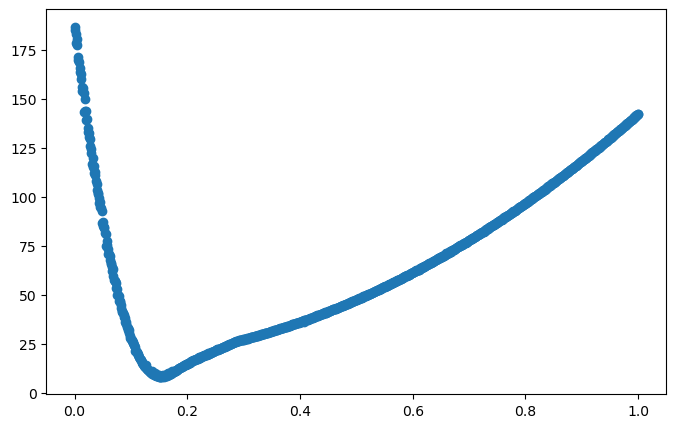

In [4]:
betas = []
lambdas = []
errors = []

for b,l,err in output:
    betas.append(b)
    lambdas.append(l)
    errors.append(err)
    
plt.figure(figsize=[8,5])
plt.scatter(x = lambdas, y = errors)

In [5]:
prob_1_results = pd.DataFrame({'Betas':betas,'Lambda':lambdas,'Errors':errors}).sort_values(by='Errors')

In [6]:
prob_1_results['Betas'].values[0]

array([-0.01694829, -0.01728077, -0.0142647 ,  0.03697723, -0.00387603,
        0.        , -0.00854997, -0.02080208, -0.01158861,  0.        ,
       -0.06825486,  1.24413282])

In [7]:
prob_1_results['Lambda'].values[0]

0.15215215215215216

In [8]:
prob_1_results['Errors'].values[0]

8.251404607004138

## Problem 2

### Part (a)

In [9]:
def DGP(k=5):
    W = np.random.normal(size=(200,1))
    for i in np.arange(49):
        new = np.random.normal(i,1,size=(200,1)) + W[:,0].reshape(200,1)
        W = np.concatenate((W,new),axis=1)
    D = np.random.rand(200,1) * 10 + (W @ (np.random.poisson(lam=5, size=(50,1)) + 1)).reshape(200,1)
    Y = (D * 5 + W[:,:k] @ np.linspace(0.1,1,k).reshape(k,1) + np.random.normal(size=(200,1))).flatten()
    X = np.concatenate((D,W),axis=1)
    return D,W,X,Y

### Part (b)

In [10]:
from sklearn.linear_model import LinearRegression, LassoCV
import cvxpy as cp

(CVXPY) Jan 30 09:30:08 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [11]:
def np_standardize(arr):
    return (arr - np.mean(arr,axis=0))/np.std(arr,axis=0)

def OLS(X,Y):
    ols = LinearRegression().fit(X,Y)
    beta_1 = ols.coef_.flatten()[0]
    return beta_1

def Lasso(X,Y):
    X = np_standardize(X)
    lasso = LassoCV().fit(X,Y)
    beta_1 = lasso.coef_.flatten()[0]
    return beta_1

def Dantzig(X,Y):
    X = np_standardize(X)
    n = X.shape[0]
    p = X.shape[1]
    lambda_ = np.sqrt(2 * np.log(p)) / n
    
    betas = cp.Variable((p,1))
    objective = cp.Minimize(cp.norm1(betas))
    constraints = [cp.abs((1/n) * cp.sum(cp.multiply(X[:,j].reshape(200,1), (Y.reshape(200,1) - cp.matmul(X,betas))))) <= lambda_ for j in range(p)]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver='ECOS')
    b_hat = betas.value
    return b_hat[0][0]

def Post(X,Y):
    # variable selection
    X_standard = np_standardize(X)
    lasso = LassoCV()
    lasso.fit(X_standard,Y)
    var_select = [i for i, coef in enumerate(lasso.coef_.flatten()) if coef != 0]
    X_select = X[:,var_select]
    
    # OLS
    beta1 = OLS(X_select,Y)
    return beta1

def Double(D,W,X,Y):
    X_standard = np_standardize(X)
    W_standard = np_standardize(W)
    # obtain gamma
    lasso1 = LassoCV().fit(W_standard,D.flatten())
    gamma = lasso1.coef_
    
    # beta1, beta2
    lasso2 = LassoCV().fit(X_standard,Y)
    beta_1 = lasso2.coef_.flatten()[0]
    beta_2 = lasso2.coef_.flatten()[1:]
    
    # estimation
    n = X.shape[0]
    num = (1/n) * (np.sum((Y - W @ beta_2) * (D.flatten() - W @ gamma)))
    denom = (1/n) * (np.sum(D.flatten() * (D.flatten() - W @ gamma)))
    beta_DL = num / denom
    return beta_DL

### Part (c)

In [12]:
def get_betas(D,W,X,Y):
    beta_ols = OLS(X,Y)
    beta_lasso = Lasso(X,Y)
    beta_dantzig = Dantzig(X,Y)
    beta_post = Post(X,Y)
    beta_double = Double(D,W,X,Y)
    return beta_ols, beta_lasso, beta_dantzig, beta_post, beta_double

def sim(i):
    D,W,X,Y = DGP()
    betas = get_betas(D,W,X,Y)
    return betas

In [13]:
with ThreadPool(max_cpu - 1) as pool:
    output = pool.map(sim,np.arange(100))

In [14]:
prob2_results = pd.DataFrame(np.array(output),columns = ['OLS', 'Lasso', 'Dantzig','Post-Lasso','Double-Lasso'])

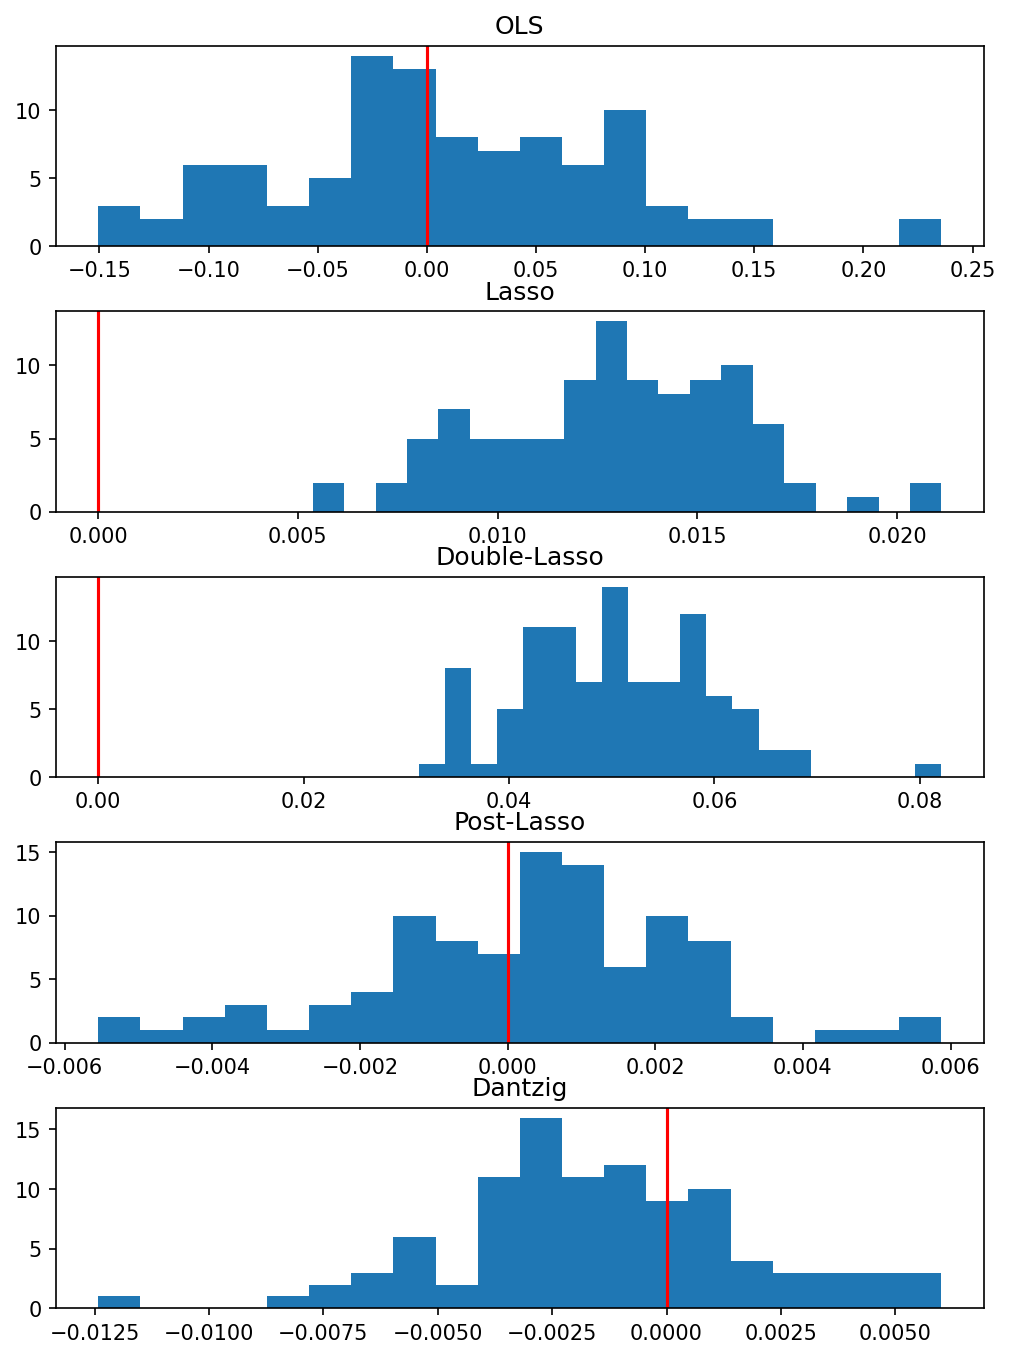

In [15]:
fig, ax = plt.subplots(nrows=prob2_results.shape[1])
fig.set_size_inches((7,9))
fig.set_dpi(150)
fig.tight_layout()
for i,name in enumerate(prob2_results.columns):
    ax[i].hist(prob2_results[name]-5,bins=20)
    ax[i].axvline(color='red')
    ax[i].set_title(name)

# Homework (Lecture 6)

## Problem 1

### Part (1)

In [16]:
X = np.array(([1,0.8,0,0],[0.8,1,0,0],[0,0,1,0.5],[0,0,0.5,1]))
eigenvals = np.linalg.eig(X)[0]
eigvecs = np.linalg.eig(X)[1].T

In [17]:
eig_df = pd.DataFrame({'vals':eigenvals,'vecs':eigvecs.tolist()}).sort_values(by='vals',ascending=False)
eig_df

,vals,vecs
0,1.8,"[0.7071067811865475, 0.7071067811865476, 0.0, ..."
2,1.5,"[0.0, 0.0, 0.7071067811865476, 0.7071067811865..."
3,0.5,"[0.0, 0.0, -0.7071067811865474, 0.707106781186..."
1,0.2,"[-0.7071067811865476, 0.7071067811865475, -0.0..."


In [18]:
v_1 = eig_df['vecs'].loc[0]
U_1 = X @ v_1

In [19]:
v_2 = eig_df['vecs'].loc[2]
U_2 = X @ v_2

In [20]:
U_1 @ U_2

0.0

### Part (2)

Yes, the result seems intuitive because much of the variance appears to be in the first two components of the covariance matrix.

### Part (3)

In [21]:
v_3 = eig_df['vecs'].loc[3]
U_3 = X @ v_3
v_4 = eig_df['vecs'].loc[1]
U_4 = X @ v_4

In [22]:
print(U_3 @ U_2)
print(U_3 @ U_1)

print(U_4 @ U_3)
print(U_4 @ U_2)
print(U_4 @ U_1)

3.3306690738754696e-16
0.0
0.0
0.0
-3.0531133177191805e-16


### Part (4)

In [23]:
sigma = np.array([[1,0.8,0.8,0.4,0.4],
                  [0.8,1,0.8,0,0],
                  [0.8,0.8,1,0,0],
                  [0.4,0,0,1,0.5],
                  [0.4,0,0,0.5,1]])

In [24]:
A = np.concatenate((np.array([1,0,0,0,0],ndmin=2),np.concatenate((np.zeros((4,1)),np.column_stack((v_1,v_2,v_3,v_4)).T),axis=1)),axis=0)

In [25]:
A

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.        , -0.70710678,  0.70710678],
       [ 0.        , -0.70710678,  0.70710678, -0.        , -0.        ]])

In [26]:
(A @ sigma @ A.T).round(3)

array([[ 1.   ,  1.131,  0.566,  0.   , -0.   ],
       [ 1.131,  1.8  ,  0.   ,  0.   , -0.   ],
       [ 0.566,  0.   ,  1.5  ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.5  ,  0.   ],
       [-0.   , -0.   ,  0.   ,  0.   ,  0.2  ]])

### Part (5)

In [27]:
gam_1 = 1.131 / 1.8
gam_2 = 0.566 / 1.5
print(gam_1)
print(gam_2)

0.6283333333333333
0.3773333333333333


$y-u'\gamma = (1, -\gamma) (y, u)'$

$(1, -\gamma) = (1, -0.628, -0.38, 0, 0)$


In [28]:
G = np.array([1,-gam_1,-gam_2,0,0],ndmin=2)
G @ A @ sigma @ A.T @ G.T

array([[0.0755557]])

g ~ N(0,0.0755557)

$\mathbb{E}[(y-u'\gamma)^2] = \mathbb{E}[g^2]$

$= Var(g) - \mathbb{E}[g]^2$

$=0.0755557$

## Problem 2

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
def factor_dgp(k,n=200,p=50):
    mu = np.array([np.random.uniform(low=0,high=1,size=k) for _ in np.arange(n)])
    f = np.array([np.random.normal(0,1,size=k) for _ in np.arange(p)]).reshape(k,p)
    W = mu @ f
    D = np.where(W[:,1] > 0,1,0).reshape(200,1) + 1
    Z = W + np.array([np.random.normal(0,10,size=p) for _ in np.arange(n)])
    Y = (5 * D + W @ (1 * np.ones((50,1))) + np.random.normal(0,10)).flatten()
    return Y,D,W,Z

def ols(Y,D,Z):
    X = np.concatenate((D,Z),axis=1)
    ols = LinearRegression().fit(X,Y)
    beta_1 = ols.coef_.flatten()[0]
    return beta_1

def double_pcr(k,Y,D,Z):
    # getting W_hat
    U, d, V = np.linalg.svd(Z)
    zrow, zcol = Z.shape
    diag = np.zeros((zrow, zcol), int)
    np.fill_diagonal(diag,d)
    w_hat = U[:,:k] @ diag[:k,:k] @ V[:,:k].T
    w_hat_k = w_hat[:,:k]
    
    # getting beta_2
    ols1 = LinearRegression().fit(np.concatenate((D,w_hat_k),axis=1),Y)
    beta_2 = ols1.coef_.flatten()[1:]
    
    # getting gamma
    ols2 = LinearRegression().fit(w_hat_k,D.flatten())
    gamma = ols2.coef_.flatten()
    
    num = (Y - w_hat_k @ beta_2) * (D.flatten() - w_hat_k @ gamma)
    denom = D.flatten() * (D.flatten() - w_hat_k @ gamma)
    beta_1 = sum(num) / sum(denom)
    return beta_1

In [31]:
def pcr_sim(i):
    ols_results = []
    dpcr_results = []
    for k_guess in [9,10,11]:
        Y,D,W,Z = factor_dgp(k=10)
        beta_ols = ols(Y=Y,D=D,Z=Z)
        beta_dpcr = double_pcr(k=k_guess,Y=Y,D=D,Z=Z)
        ols_results.append(beta_ols)
        dpcr_results.append(beta_dpcr)
    return ols_results, dpcr_results

In [32]:
with ThreadPool(max_cpu - 1) as pool:
    output_pcr = pool.map(pcr_sim,np.arange(1000))

In [33]:
results_prob2_pcr = pd.concat([pd.Series([9,10,11]*1000,name='k',index=np.arange(0,3000)),pd.DataFrame(output_pcr,columns=['OLS','Double-PCR']).apply(pd.Series.explode).set_index(np.arange(0,3000))],axis=1)

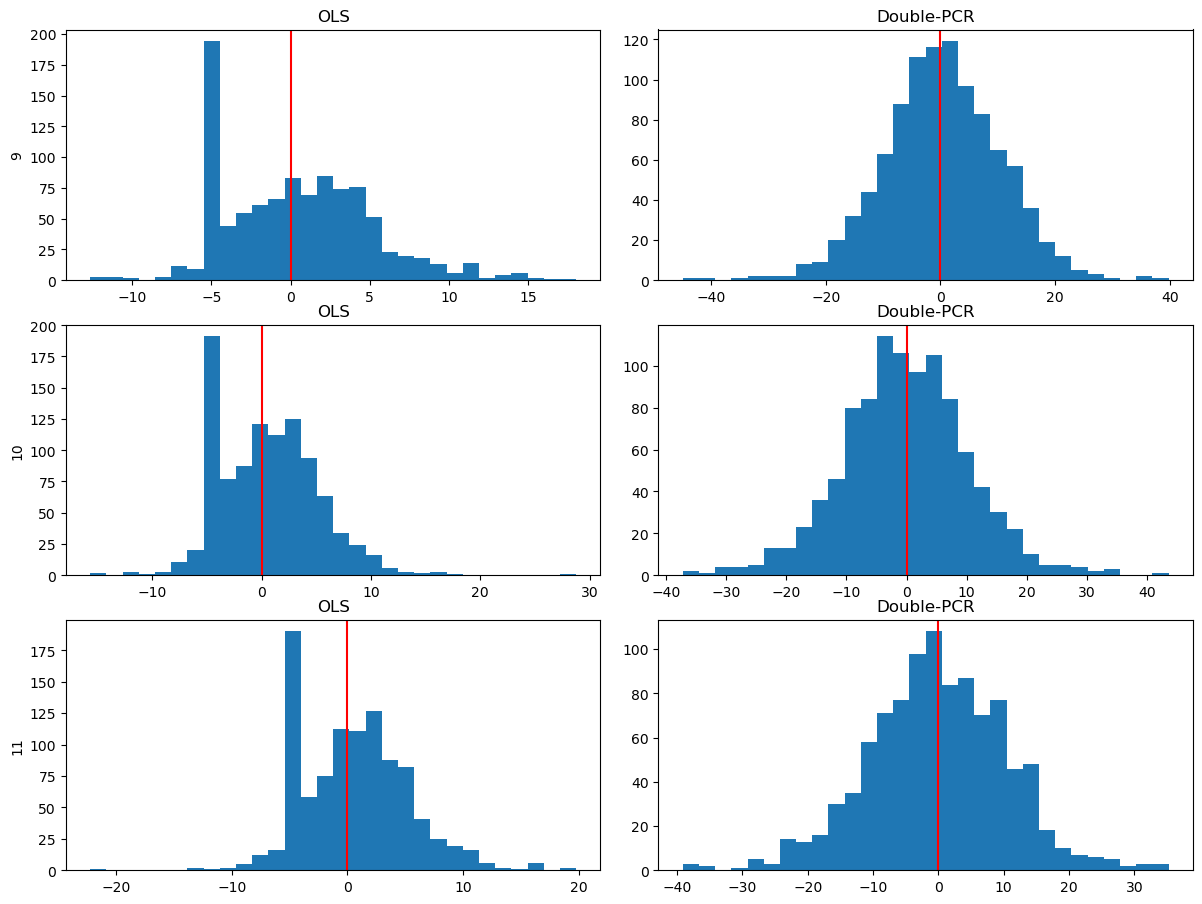

In [34]:
fig, ax = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches((12,9))
fig.set_dpi(100)
fig.tight_layout()
k=[9,10,11]
for i,k_ in enumerate(k):
    ax[i,0].hist(results_prob2_pcr[results_prob2_pcr['k']==k_]['OLS']-5,bins=30)
    ax[i,0].axvline(color='red')
    ax[i,0].set_title('OLS')
    ax[i,0].set_ylabel(k_)
    ax[i,1].hist(results_prob2_pcr[results_prob2_pcr['k']==k_]['Double-PCR']-5,bins=30)
    ax[i,1].axvline(color='red')
    ax[i,1].set_title('Double-PCR')